In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import pickle

import torch
import torch.utils.data as data_utils

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/kaggle/input/eestech-challenge-2022/Train-dataset.csv')

In [3]:
df_copy = df.copy(deep=True);

classes_num = 15; # number of output classes
values_num = len(df_copy['LITH_CODE']); # number of values in dataset

env_num = len(df_copy['DEPOSITIONAL_ENVIRONMENT'].unique());

#one_hot_class = [[0 for col in range(values_num)] for row in range(classes_num)];
one_hot_env = [[0 for col in range(values_num)] for row in range(env_num)];

help_dict_class = {
100 : 0,
200 : 1,
300 : 2,
400 : 3,
500 : 4,
600 : 5,
700 : 6,
800 : 7,
900 : 8,
1000 : 9,
1100 : 10,
1200 : 11,
1300 : 12,
1400 : 13,
1500 : 14
};

help_dict_env = {
'Continental': 0,
'Transitional': 1,
'Marine': 2,
};


for i in range(values_num):
    ind = help_dict_class[df_copy['LITH_CODE'][i]];
    df_copy['LITH_CODE'][i] = help_dict_class[df_copy['LITH_CODE'][i]];
   # one_hot_class[ind][i] = 1;

    ind = help_dict_env[df_copy['DEPOSITIONAL_ENVIRONMENT'][i]];
    one_hot_env[ind][i] = 1;
    '''
for i in range(classes_num):
    name = "classNo" + str(i);
    df_copy[name] = one_hot_class[i];
'''
for i in range(env_num):
    name = "envNo" + str(i);
    df_copy[name] = one_hot_env[i];
    

df_copy['X'] = (df_copy['X'] - df_copy['X'].min()) / (df_copy['X'].max() - df_copy['X'].min());
df_copy['Y'] = (df_copy['Y'] - df_copy['Y'].min()) / (df_copy['Y'].max() - df_copy['Y'].min());
df_copy['MD'] = (df_copy['MD'] - df_copy['MD'].min()) / (df_copy['MD'].max() - df_copy['MD'].min());
df_copy['GR'] = (df_copy['GR'] - df_copy['GR'].min()) / (df_copy['GR'].max() - df_copy['GR'].min());
df_copy['RT'] = (df_copy['RT'] - df_copy['RT'].min()) / (df_copy['RT'].max() - df_copy['RT'].min());
df_copy['CN'] = (df_copy['CN'] - df_copy['CN'].min()) / (df_copy['CN'].max() - df_copy['CN'].min());
df_copy['DEN'] = (df_copy['DEN'] - df_copy['DEN'].min()) / (df_copy['DEN'].max() - df_copy['DEN'].min());

#display(df_copy.head(100))

df = df_copy

In [4]:
selector = 2  #0-welldropping 1-stratified 2-whole set
well_no = 0
y = df['LITH_CODE']
X = df[['MD','GR', 'RT', 'DEN', 'CN','envNo0', 'envNo1','envNo2']]
if selector == 0:
    wells = df['WELL'].unique()
    victim_well = wells[well_no]
    df_well1 = df[df['WELL'] == victim_well]
    df = df[df['WELL'] != victim_well]
    y_train = df['LITH_CODE']
    X_train = df[['MD','GR', 'RT', 'DEN', 'CN','envNo0', 'envNo1','envNo2']]

    y_test = df_well1['LITH_CODE']
    X_test = df_well1[['MD','GR', 'RT', 'DEN', 'CN','envNo0', 'envNo1','envNo2']]
elif selector==1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 4, stratify = y)
else:
    X_train = X
    y_train = y
    X_test = X
    y_test = y

In [5]:
target_tensor_train = torch.tensor(y_train.values, dtype=torch.long)
features_tensor_train = torch.tensor(X_train.values, dtype=torch.float32)

target_tensor_test = torch.tensor(y_test.values, dtype=torch.long)
features_tensor_test = torch.tensor(X_test.values, dtype=torch.float32)

train = data_utils.TensorDataset(features_tensor_train, target_tensor_train)
test = data_utils.TensorDataset(features_tensor_test, target_tensor_test)

train_loader = data_utils.DataLoader(train, batch_size=100, shuffle=True) #promeni batch size
test_loader = data_utils.DataLoader(test, batch_size=100, shuffle=True) #promeni batch size

In [6]:
class MyNetwork(nn.Module):
    def __init__(self):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.fc1 = nn.Linear(8, 18)
        self.fc2 = nn.Linear(18, 32)
        self.fc3 = nn.Linear(32, 15)
        self.m = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        # define forward pass

        x = F.relu(self.fc1(x))
        x = self.m(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
def measure_quality(model, dataset):
    model.eval()
    iteration_cnt = 0

    all_preds = list()
    all_labels = list()

    with torch.no_grad():
        for i, data in enumerate(dataset):
                
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            all_preds += list(pred.data.cpu().numpy())
            all_labels += list(labels.data.cpu().numpy())

            iteration_cnt += 1

    model.train()
    return round(metrics.f1_score(all_labels, all_preds, average = 'micro'), 2)

In [9]:
def get_preds(model, dataset):
    model.eval()
    iteration_cnt = 0

    all_preds = list()
    all_labels = list()

    with torch.no_grad():
        for i, data in enumerate(dataset):
                
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            all_preds += list(pred.data.cpu().numpy())
            all_labels += list(labels.data.cpu().numpy())

            iteration_cnt += 1

    model.train()

    return all_labels, all_preds

In [10]:
net = MyNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            val_accuracy = measure_quality(net, test_loader)
            print(f"epoch {epoch + 1} iter {i + 1} loss: {running_loss / 100} test accuracy: {val_accuracy}")
            running_loss = 0.0
    train_acc = measure_quality(net, train_loader) 
    print(epoch,f' epoha gotova acc na tr:{train_acc}')

print('Finished Training')

epoch 1 iter 100 loss: 1.6714328837394714 test accuracy: 0.66
epoch 1 iter 200 loss: 1.342177460193634 test accuracy: 0.67
epoch 1 iter 300 loss: 1.3023068827390671 test accuracy: 0.68
epoch 1 iter 400 loss: 1.2569601595401765 test accuracy: 0.68
0  epoha gotova acc na tr:0.68
epoch 2 iter 100 loss: 1.2305881780385972 test accuracy: 0.65
epoch 2 iter 200 loss: 1.2283390432596206 test accuracy: 0.66
epoch 2 iter 300 loss: 1.2120787167549134 test accuracy: 0.7
epoch 2 iter 400 loss: 1.2182947754859925 test accuracy: 0.66
1  epoha gotova acc na tr:0.68
epoch 3 iter 100 loss: 1.2021726697683335 test accuracy: 0.69
epoch 3 iter 200 loss: 1.152772268652916 test accuracy: 0.68
epoch 3 iter 300 loss: 1.1976233333349229 test accuracy: 0.66
epoch 3 iter 400 loss: 1.221001997590065 test accuracy: 0.69
2  epoha gotova acc na tr:0.65
epoch 4 iter 100 loss: 1.2086418867111206 test accuracy: 0.68
epoch 4 iter 200 loss: 1.1938521182537079 test accuracy: 0.68
epoch 4 iter 300 loss: 1.230777349472046 te

In [16]:
y_predict, tg = get_preds(net, test_loader)

In [19]:
def show_conf_matrix(y_test, y_pred, classes):
    
    # Calculate confusion matrix
    conf = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15,15))
    sns.set(font_scale=1)
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt="d", linewidths=.5, cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted value')
    plt.ylabel('True value')
    
    plt.show()

In [22]:
import seaborn as sns

Train set accuracy:  0.63
Test set accuracy:  0.63


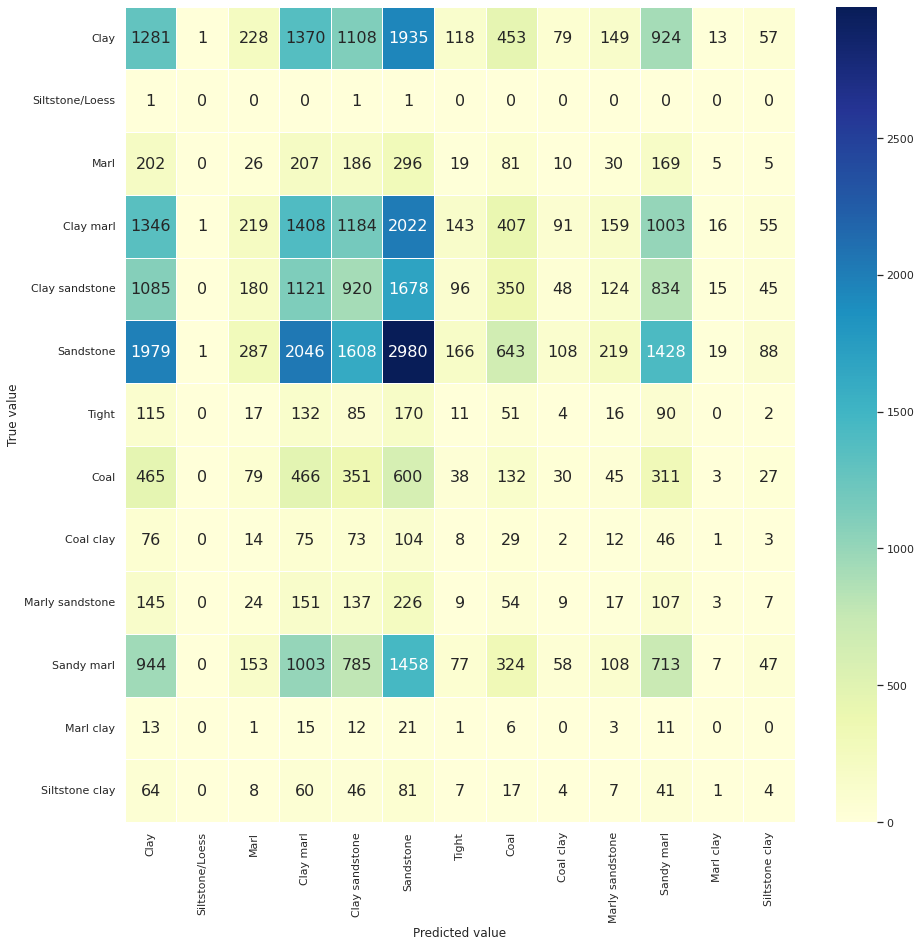

Test set classification report
----------------------------------------------------------------------------------
                 precision    recall  f1-score   support

           Clay       0.99      0.50      0.66     15278
Siltstone/Loess       0.00      0.00      0.00         0
           Marl       0.00      0.00      0.00         0
      Clay marl       0.93      0.71      0.81     10511
 Clay sandstone       0.00      0.00      0.00         0
      Sandstone       0.92      0.78      0.84     13645
          Tight       0.48      0.76      0.59       441
           Coal       0.07      0.58      0.12       292
      Coal clay       0.00      0.00      0.00         0
Marly sandstone       0.00      0.00      0.00         0
     Sandy marl       0.46      0.47      0.46      5582
      Marl clay       0.00      0.00      0.00         0
 Siltstone clay       0.00      0.00      0.00         0

       accuracy                           0.63     45749
      macro avg       0.30   

In [25]:
lithology_key = {100: 'Clay',
                 200: 'Siltstone/Loess',
                 300: 'Marl',
                 400: 'Clay marl',
                 500: 'Clay sandstone',
                 600: 'Sandstone',
                 700: 'Limestone',
                 800: 'Tight',
                 900: 'Dolomite',
                 1000: 'Coal',
                 1100: 'Coal clay',
                 1200: 'Marly sandstone',
                 1300: 'Sandy marl',
                 1400: 'Marl clay',
                 1500: 'Siltstone clay'
                  }

lithology_num = {0: 'Clay',
                 1: 'Siltstone/Loess',
                 2: 'Marl',
                 3: 'Clay marl',
                 4: 'Clay sandstone',
                 5: 'Sandstone',
                 6: 'Limestone',
                 7: 'Tight',
                 8: 'Dolomite',
                 9: 'Coal',
                 10: 'Coal clay',
                 11: 'Marly sandstone',
                 12: 'Sandy marl',
                 13: 'Marl clay',
                 14: 'Siltstone clay'
                  }

target_lithologys = []
labels = np.sort(y_test.unique())

for l_code in labels:
    lithology = lithology_num[l_code]
    target_lithologys.append(lithology)



print("Train set accuracy: ", round(metrics.f1_score(tg, y_predict, average = 'micro'), 2))
print("Test set accuracy: ", round(metrics.f1_score(tg, y_predict, average = 'micro'), 2))

show_conf_matrix(y_predict, y_test, target_lithologys)

print('==================================================================================')
print('Test set classification report')
print('----------------------------------------------------------------------------------')
print(classification_report(tg, y_predict, labels=labels, target_names=target_lithologys, zero_division=0))
print('==================================================================================')

# Validate your model

In [11]:
df2 = pd.read_csv('/kaggle/input/eestech-challenge-2022/Test-dataset.csv')

In [12]:
df2_copy = df2.copy(deep = True)

env_num2 = len(df2_copy['DEPOSITIONAL_ENVIRONMENT'].unique());



for i in range(env_num2):
    name = "envNo" + str(i);
    df2_copy[name] = 0

for i in range(len(df2_copy['DEPOSITIONAL_ENVIRONMENT'])):
    if(df2_copy['DEPOSITIONAL_ENVIRONMENT'][i] == 'Continental'):
        df2_copy['envNo0'][i] = 1
    elif(df2_copy['DEPOSITIONAL_ENVIRONMENT'][i] == 'Marine'):
        df2_copy['envNo2'][i] = 1
    else:
        df2_copy['envNo1'][i] = 1

df2_copy['X'] = (df2_copy['X'] - df2_copy['X'].min()) / (df2_copy['X'].max() - df2_copy['X'].min());
df2_copy['Y'] = (df2_copy['Y'] - df2_copy['Y'].min()) / (df2_copy['Y'].max() - df2_copy['Y'].min());
df2_copy['MD'] = (df2_copy['MD'] - df2_copy['MD'].min()) / (df2_copy['MD'].max() - df2_copy['MD'].min());
df2_copy['GR'] = (df2_copy['GR'] - df2_copy['GR'].min()) / (df2_copy['GR'].max() - df2_copy['GR'].min());
df2_copy['RT'] = (df2_copy['RT'] - df2_copy['RT'].min()) / (df2_copy['RT'].max() - df2_copy['RT'].min());
df2_copy['CN'] = (df2_copy['CN'] - df2_copy['CN'].min()) / (df2_copy['CN'].max() - df2_copy['CN'].min());
df2_copy['DEN'] = (df2_copy['DEN'] - df2_copy['DEN'].min()) / (df2_copy['DEN'].max() - df2_copy['DEN'].min());

df2 = df2_copy

In [13]:
test_inputs = df2[['MD','GR', 'RT', 'DEN', 'CN','envNo0', 'envNo1','envNo2']]


In [14]:
test_tensor = torch.tensor(test_inputs.values, dtype=torch.float32)

test = data_utils.TensorDataset(test_tensor, test_tensor)

test_loader = data_utils.DataLoader(test, batch_size=100) #promeni batch size

In [15]:
def get_preds(model, dataset):
    model.eval()


    all_preds = list()

    with torch.no_grad():
        for i, data in enumerate(dataset):
                
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)

            all_preds += list(pred.data.cpu().numpy())

    model.train()

    return all_preds

In [16]:
preds = get_preds(net, test_loader)

In [17]:
preds

[4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,


In [18]:
y_pred_final = [round((x+1)*100) for x in preds]

In [19]:
y_pred_final

[500,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 500,
 500,
 500,
 500,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 500,
 500,
 100,
 100,
 100,
 100,
 100,
 100,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 1000,
 100,
 100,
 100,
 100,
 100,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 500,
 500,
 500,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 100,
 500,
 500,
 500,
 500,
 500,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 600,
 60

In [20]:
df2['LITH_CODE'] = y_pred_final

In [21]:
df2

,Id,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,envNo0,envNo1,envNo2,LITH_CODE
0,1,Well-X,1.000000,0.0,0.228251,0.534758,0.036873,0.414133,0.613302,Continental,1,0,0,500
1,2,Well-X,1.000000,0.0,0.228341,0.545829,0.035148,0.424343,0.607792,Continental,1,0,0,100
2,3,Well-X,1.000000,0.0,0.228432,0.554601,0.032549,0.441150,0.602519,Continental,1,0,0,100
3,4,Well-X,1.000000,0.0,0.228523,0.561920,0.029943,0.460452,0.598898,Continental,1,0,0,100
4,5,Well-X,1.000000,0.0,0.228613,0.569707,0.029649,0.479266,0.599134,Continental,1,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28992,28993,Well-Z,0.375895,1.0,0.972546,0.683857,0.017824,0.333589,0.769776,Marine,0,0,1,400
28993,28994,Well-Z,0.375895,1.0,0.972637,0.677461,0.018052,0.330640,0.772216,Marine,0,0,1,400
28994,28995,Well-Z,0.375895,1.0,0.972728,0.677265,0.018346,0.325788,0.774183,Marine,0,0,1,400
28995,28996,Well-Z,0.375895,1.0,0.972819,0.683176,0.018785,0.319837,0.776151,Marine,0,0,1,400


In [23]:
submission = df2[['Id','LITH_CODE']]

In [24]:
submission

,Id,LITH_CODE
0,1,500
1,2,100
2,3,100
3,4,100
4,5,100
...,...,...
28992,28993,400
28993,28994,400
28994,28995,400
28995,28996,400


In [25]:
submission.to_csv('submission.csv', index=False)